In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Members of the intersection of both the 115th and 116th US Congress
# All of these members where there during the whole 2016-2020 period (both 115th & 116th congress)
congress = pd.read_csv("/content/drive/MyDrive/ADA/congress_115_116.csv")

In [4]:
congress.head()

,Unnamed: 0,fec_candidate_id,speaker,short_title,last_name,first_name,party,date_of_birth,gender,state
0,0,H4LA05221,ralph abraham,Rep.,Abraham,Ralph,R,1954-09-16,M,LA
1,1,H4NC12100,alma adams,Rep.,Adams,Alma,D,1946-05-27,F,NC
2,2,H6AL04098,robert aderholt,Rep.,Aderholt,Robert,R,1965-07-22,M,AL
3,3,H2CA31125,pete aguilar,Rep.,Aguilar,Pete,D,1979-06-19,M,CA
4,4,H2GA12121,rick allen,Rep.,Allen,Rick,R,1951-11-07,M,GA


In [5]:
%%time 
# link to the Drive repo + the year of the newpapers quotes
path_to_file = '/content/drive/MyDrive/ADA/quotes-2018-congress-speakers.json.bz2'
# here the data is in the ADA folder placed at the root of your Drive

quotes_2018_congress = []
with bz2.open(path_to_file, 'rb') as s_file:
    for i, sample in enumerate(s_file):
      quote = json.loads(sample)
      quotes_2018_congress.append(quote)

CPU times: user 21.3 s, sys: 813 ms, total: 22.1 s
Wall time: 22.6 s


In [6]:
# Transforming the array of quotes in a pandas DataFrame
df_2018_congress = pd.DataFrame(quotes_2018_congress)
df_2018_congress.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-01-25-000523,[ the former HHS secretary ] has said he has h...,Bill Flores,[Q862103],2018-01-25 03:23:08,1,"[[Bill Flores, 0.779], [None, 0.1342], [Presid...",[http://www.breitbart.com/big-government/2018/...,E
1,2018-02-07-001740,A disproportionate number of the MS-13 members...,Peter King,"[Q15840165, Q16104898, Q2076274, Q21063831, Q2...",2018-02-07 05:00:00,2,"[[Peter King, 0.5021], [None, 0.4344], [Presid...",[https://www.wsws.org/en/articles/2018/02/07/i...,E
2,2018-10-02-001499,"A group that did it their way,",Christopher Smith,"[Q47036897, Q5108104, Q5113247, Q5113248, Q511...",2018-10-02 14:36:42,1,"[[Christopher Smith, 0.9112], [None, 0.0568], ...",[https://www.highsnobiety.com/p/the-internet-h...,E
3,2018-01-07-002036,All I can say is it's not a hoax. The Russians...,Lindsey Graham,[Q22212],2018-01-07 15:40:00,1,"[[Lindsey Graham, 0.5251], [None, 0.2936], [Ch...",[http://postandcourier.com/politics/would-lind...,E
4,2018-05-08-005589,"Although I opposed the agreement, in part beca...",Alcee Hastings,[Q1758631],2018-05-08 21:11:51,1,"[[Alcee Hastings, 0.6473], [None, 0.1927], [Lo...",[http://www.mypalmbeachpost.com/news/national-...,E


In [7]:
# Counting the number of quotes by each member of the congress
df_2018_congress["speaker"].str.lower().value_counts()

lindsey graham      11412
nancy pelosi        10133
mitch mcconnell      9205
marco rubio          7350
elizabeth warren     7126
                    ...  
e wilson                4
catherine cortez        3
rick mc                 2
peter visclosky         2
david per               1
Name: speaker, Length: 410, dtype: int64

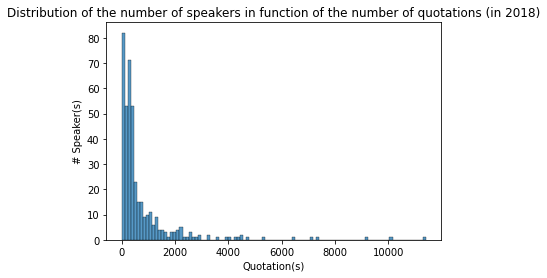

CPU times: user 546 ms, sys: 22 ms, total: 568 ms
Wall time: 589 ms


In [8]:
%%time
# Distribution of the number(#) of speakers in function of the # of quotes

ax11 = sns.histplot(data = df_2018_congress["speaker"].str.lower().value_counts(), bins=100)
ax11.set_title('Distribution of the number of speakers in function of the number of quotations (in 2018)')
ax11.set_ylabel('# Speaker(s)')
ax11.set_xlabel('Quotation(s)')
plt.show()

In [9]:
df_2018_congress["speaker"] = df_2018_congress["speaker"].str.lower()
df_2018_congress_merged = pd.merge(df_2018_congress, congress[["speaker", "party", "gender", "date_of_birth", 'state']], on=["speaker"], how='left')
df_2018_congress_merged.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,party,gender,date_of_birth,state
0,2018-01-25-000523,[ the former HHS secretary ] has said he has h...,bill flores,[Q862103],2018-01-25 03:23:08,1,"[[Bill Flores, 0.779], [None, 0.1342], [Presid...",[http://www.breitbart.com/big-government/2018/...,E,R,M,1954-02-25,TX
1,2018-02-07-001740,A disproportionate number of the MS-13 members...,peter king,"[Q15840165, Q16104898, Q2076274, Q21063831, Q2...",2018-02-07 05:00:00,2,"[[Peter King, 0.5021], [None, 0.4344], [Presid...",[https://www.wsws.org/en/articles/2018/02/07/i...,E,R,M,1944-04-05,NY
2,2018-10-02-001499,"A group that did it their way,",christopher smith,"[Q47036897, Q5108104, Q5113247, Q5113248, Q511...",2018-10-02 14:36:42,1,"[[Christopher Smith, 0.9112], [None, 0.0568], ...",[https://www.highsnobiety.com/p/the-internet-h...,E,R,M,1953-03-04,NJ
3,2018-01-07-002036,All I can say is it's not a hoax. The Russians...,lindsey graham,[Q22212],2018-01-07 15:40:00,1,"[[Lindsey Graham, 0.5251], [None, 0.2936], [Ch...",[http://postandcourier.com/politics/would-lind...,E,R,M,1955-07-09,SC
4,2018-05-08-005589,"Although I opposed the agreement, in part beca...",alcee hastings,[Q1758631],2018-05-08 21:11:51,1,"[[Alcee Hastings, 0.6473], [None, 0.1927], [Lo...",[http://www.mypalmbeachpost.com/news/national-...,E,D,M,1936-09-05,FL


In [10]:
# Number of quotes for this dataset
quotes_number_2018 = df_2018_congress_merged.shape[0]
print(f' Total number of quotes for congress dataset 2018: {quotes_number_2018}')

 Total number of quotes for congress dataset 2018: 305669


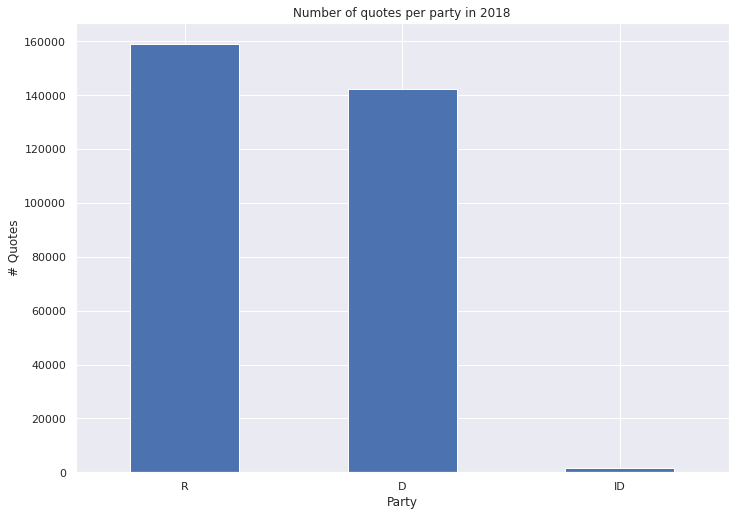

,party
R,158899
D,142277
ID,1502


In [11]:
#-------------------Political party------------------------

df_party = df_2018_congress_merged['party'].value_counts().to_frame()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax2 = df_party.plot(kind='bar', rot=0, legend = False)
ax2.set_title("Number of quotes per party in 2018")
ax2.set_ylabel('# Quotes')
ax2.set_xlabel('Party')
plt.show()
df_party

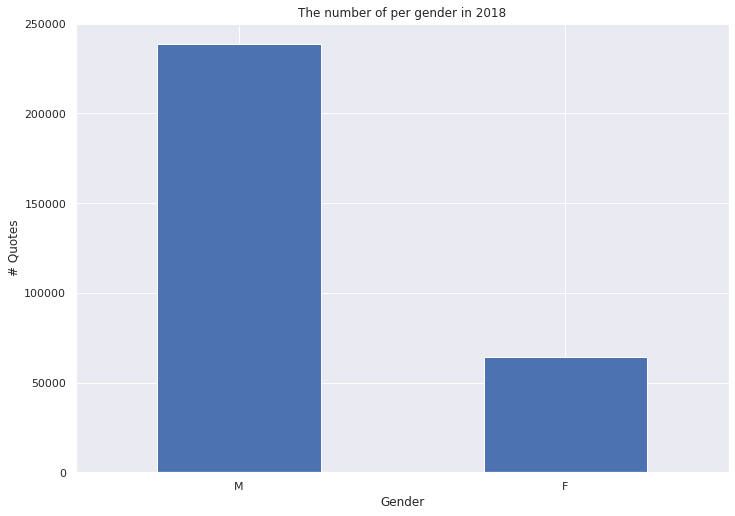

,gender
M,238579
F,64099


In [12]:
#-----------------Gender-----------------

df_gender = df_2018_congress_merged['gender'].value_counts().to_frame()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax3 = df_gender.plot(kind='bar', rot=0, legend = False)
ax3.set_title('The number of per gender in 2018')
ax3.set_ylabel('# Quotes')
ax3.set_xlabel('Gender')
plt.show()
df_gender

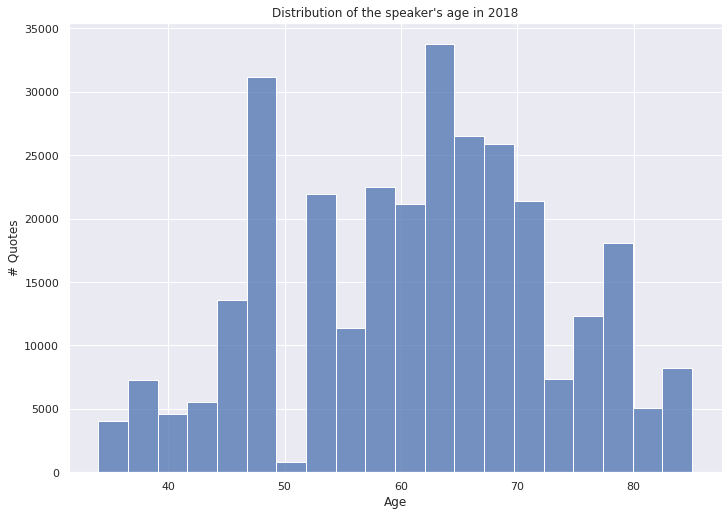

,age
mean,61.357089
50%,63.000000
min,34.000000
max,85.000000


In [13]:
#-----------------Age-----------------

df_2018_congress_merged['year_of_birth'] = pd.DatetimeIndex(df_2018_congress_merged['date_of_birth']).year.astype('Int64')
df_2018_congress_merged['age'] = (2018 - df_2018_congress_merged['year_of_birth']).astype('Int64')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax3 = sns.histplot(data = df_2018_congress_merged['age'], bins=20)
ax3.set_title("Distribution of the speaker's age in 2018")
ax3.set_ylabel('# Quotes')
ax3.set_xlabel('Age')
plt.show()

df_2018_congress_merged.describe().loc[['mean', '50%', 'min', 'max'],['age']]


     |████████████████████████████████| 1.0 MB 20.3 MB/s 
     |████████████████████████████████| 6.3 MB 79.3 MB/s 
     |████████████████████████████████| 15.4 MB 40 kB/s 


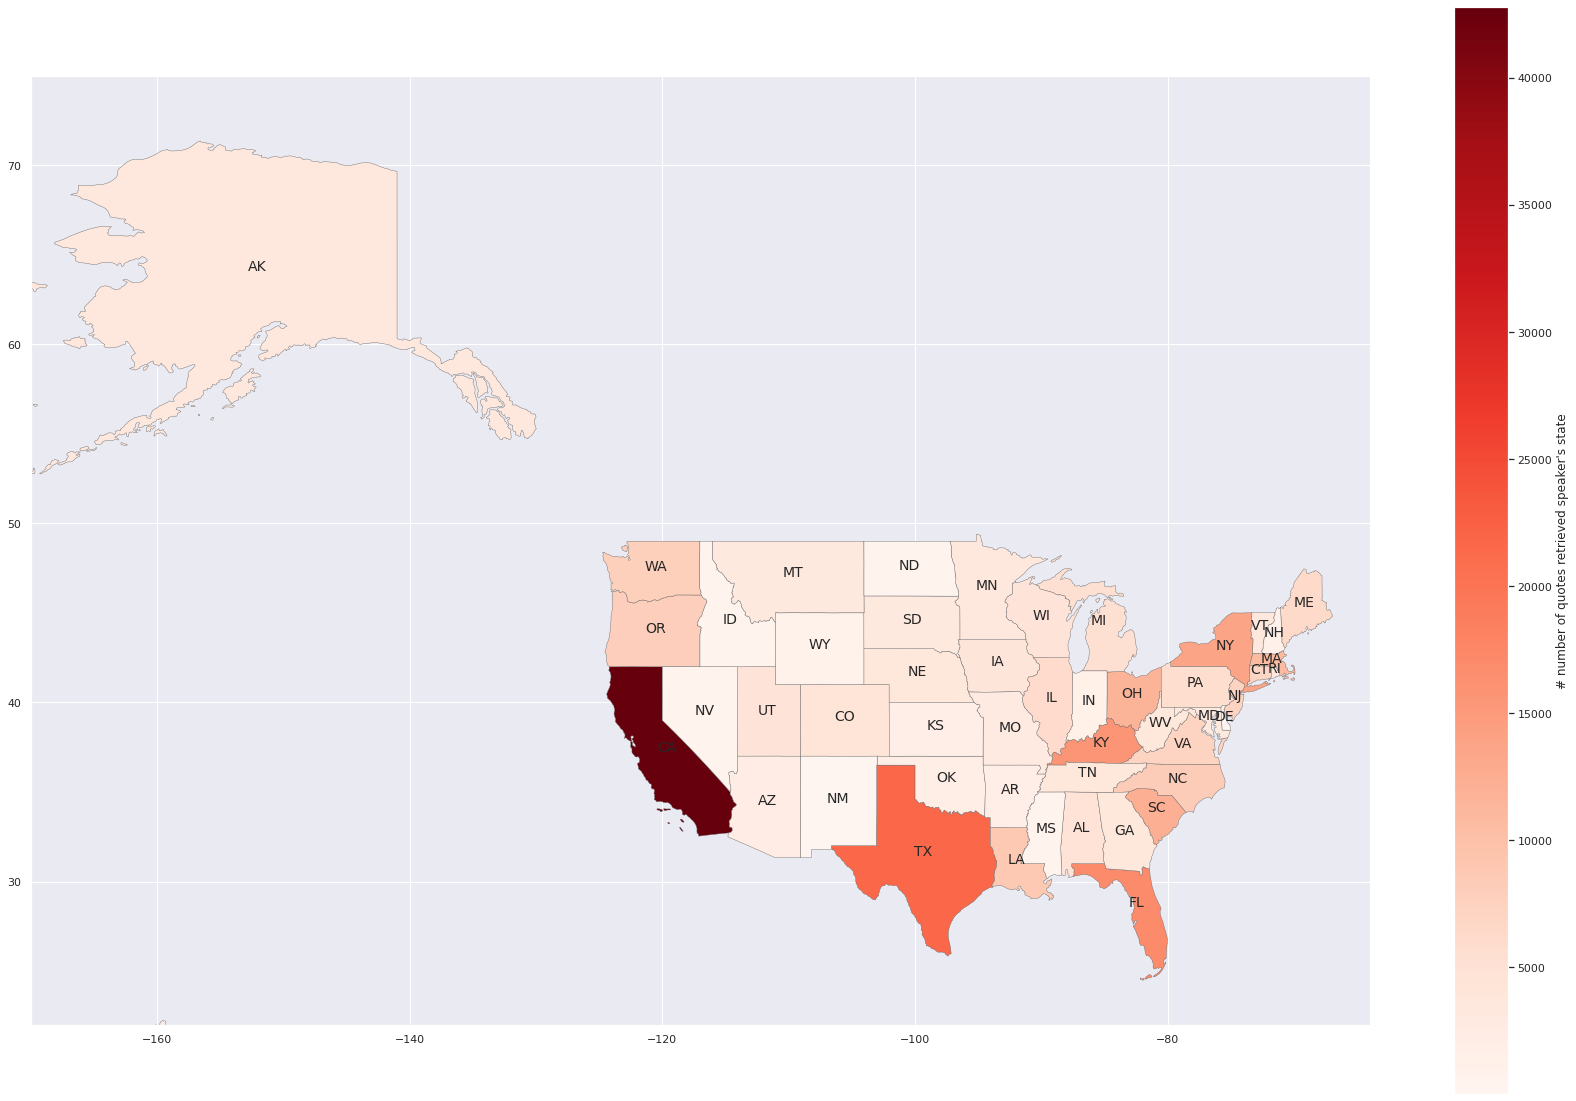

In [14]:
#--------------------State-----------------------
# Heatmap of occurences of state origin of speaker 
!pip install geopandas #to run once
import geopandas as gpd
from geopandas import GeoDataFrame
states_map = gpd.read_file("/content/drive/MyDrive/map/cb_2018_us_state_20m.shp")

fig, ax = plt.subplots(1, figsize=(30, 20))
df_state = df_2018_congress_merged['state'].value_counts().to_frame()
merged = df_state.merge(states_map, left_index=True, right_on='STUSPS')
merged = GeoDataFrame(merged)
merged.apply(lambda x: ax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1);
merged.plot(column="state", cmap="Reds", ax=ax, linewidth=0.4, edgecolor=".4", legend=True, legend_kwds={'label': "# number of quotes retrieved speaker's state", 'orientation': "vertical"})
_ = ax.set_xlim([-170, -64])
_ = ax.set_ylim([22, 75])


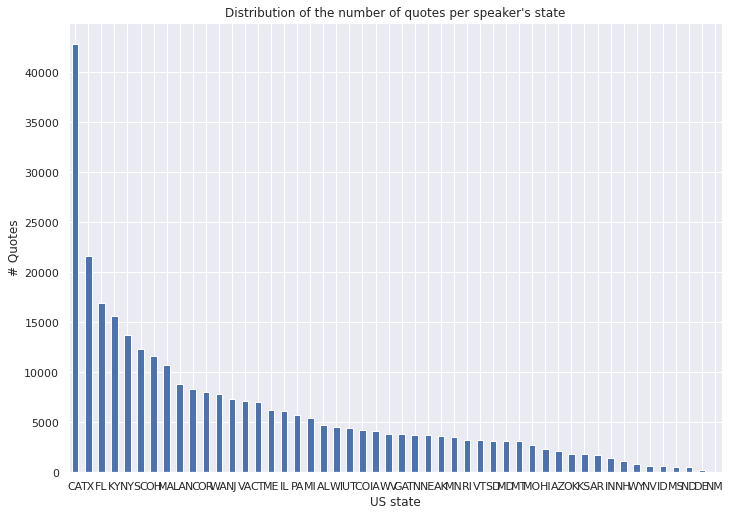

In [15]:
ax2 = df_state.plot(kind='bar', rot=0, legend = False)
ax2.set_title("Distribution of the number of quotes per speaker's state")
ax2.set_ylabel('# Quotes')
ax2.set_xlabel('US state')
plt.show()

In [16]:
# Number of quotes containing the string "climate change"

num_quotes_climate_change = np.count_nonzero(df_2018_congress_merged['quotation'].str.count('climate change'), axis=0)
print(f'Number of quotes containing the string "climate change": {num_quotes_climate_change}')

Number of quotes containing the string "climate change": 429


In [17]:
# Number of quotes containing the string 'Paris agreement'

num_quotes_paris = np.count_nonzero(df_2018_congress_merged['quotation'].str.count('Paris agreement'), axis=0)
print(f'Number of quotes containing the string "Paris agreement": {num_quotes_paris}')

Number of quotes containing the string "Paris agreement": 2


In [18]:
# Number of quotes containing the string "health insurances"

num_quotes_health_insurance = np.count_nonzero(df_2018_congress_merged['quotation'].str.count('health insurance'), axis=0)
print(f'Number of quotes containing the string "health insurances": {num_quotes_health_insurance}')

Number of quotes containing the string "health insurances": 337
